In [1]:
%matplotlib widget
import sys  
sys.path.insert(0, '/home/cbisot/pycode/MscThesis/')
from amftrack.pipeline.functions.post_processing.extract_study_zone import *
import pandas as pd
import ast
from amftrack.plotutil import plot_t_tp1
from scipy import sparse
from datetime import datetime
from amftrack.pipeline.functions.node_id import orient
import pickle
import scipy.io as sio
from pymatreader import read_mat
from matplotlib import colors
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import frangi
from skimage import filters
from random import choice
import scipy.sparse
import os
from amftrack.pipeline.functions.extract_graph import from_sparse_to_graph, generate_nx_graph, sparse_to_doc
from skimage.feature import hessian_matrix_det
from amftrack.pipeline.functions.experiment_class_surf import Experiment, Edge, Node, Hyphae, plot_raw_plus, get_hyphae
from amftrack.pipeline.paths.directory import run_parallel, find_state, directory_scratch, directory_project
from amftrack.notebooks.analysis.util import * 
from scipy import stats
from scipy.ndimage.filters import uniform_filter1d
from amftrack.pipeline.functions.hyphae_id_surf import get_pixel_growth_and_new_children
from collections import Counter
from IPython.display import clear_output
from amftrack.notebooks.analysis.data_info import *
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams.update({
    "font.family": "verdana",
'font.weight' : 'normal',
'font.size': 20})
from amftrack.plotutil import plot_node_skel
from amftrack.notebooks.validation.util import *
from amftrack.pipeline.paths.directory import *
from amftrack.util import *
from amftrack.notebooks.post_processing.util import *
import pickle

directory = directory_project
update_analysis_info(directory)
analysis_info = get_current_analysis(directory)

In [2]:
select_v7 = analysis_info.loc[(analysis_info['version']=='Version7')]
plates = set(select_v7['Plate'].values)
plates
selection = []
for plate in plates:
    select_folder = np.min(select_v7.loc[(select_v7['Plate']==plate)]['folder_analysis'])
    selection.append(select_folder)
select = select_v7.loc[(select_v7['folder_analysis'].isin(selection))]

{10, 22, 26, 76, 80, 88, 91, 94, 102, 152, 790, 792, 799, 800, 808}

In [3]:
num = 1
rows = [row for (index, row) in select.iterrows()]
for index,row in enumerate(rows):
    path = f'{directory}{row["folder_analysis"]}'
    print(index,row["Plate"])
    try:
        a = np.load(f'{path}/center.npy')
    except:
        print(index,row["Plate"])
    if index == num:
        path_exp = f'{directory}{row["path_exp"]}'
        exp = pickle.load(open(path_exp, "rb"))
        exp.dates.sort()
        break

0 22
0 22
1 808


In [15]:
row["Plate"]

102

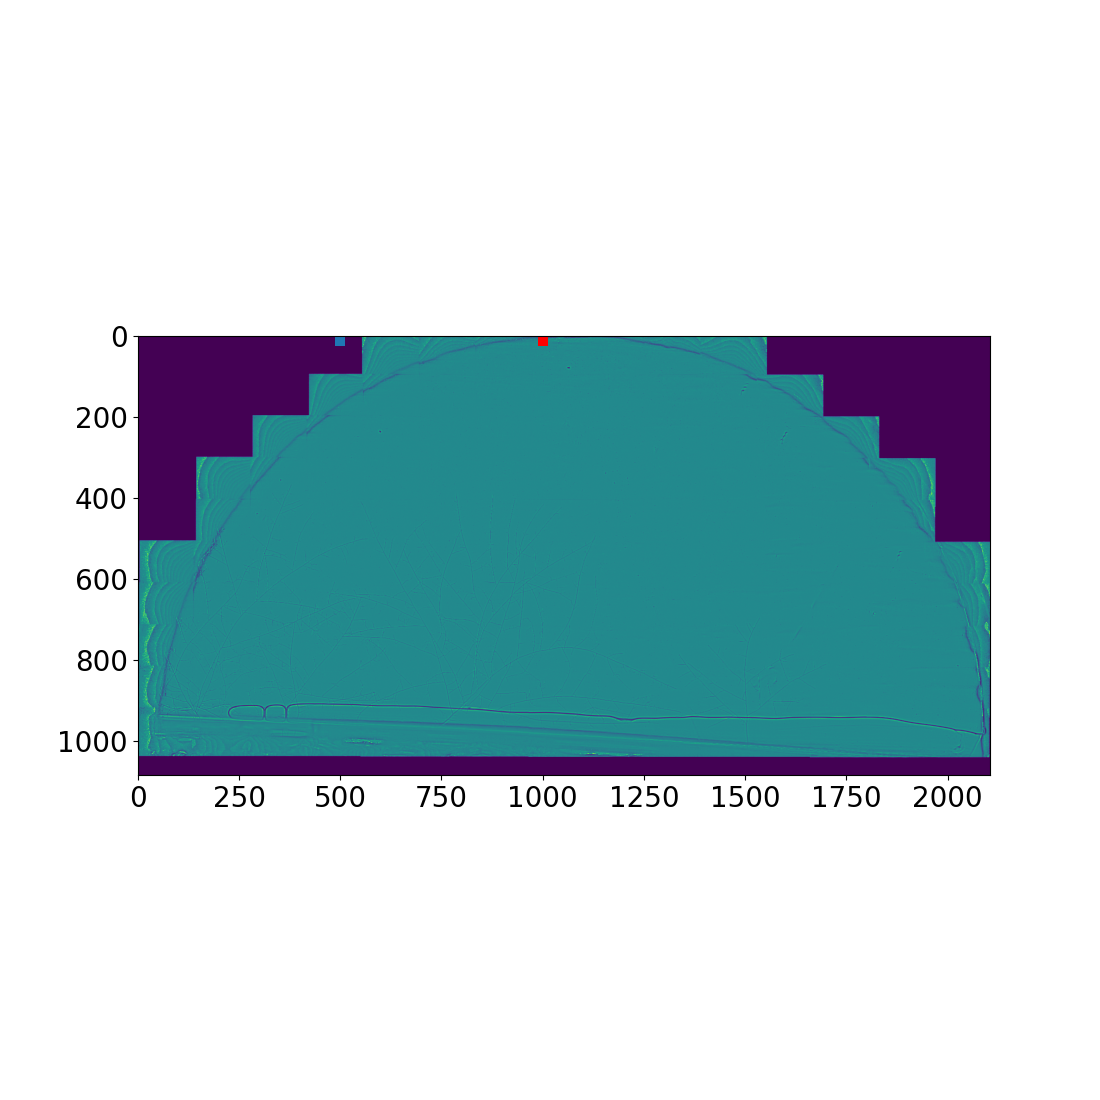

In [5]:
plt.close('all')
i=0
dist = 150
radius = 1000
compress = 25
dr_orth, dr_center = get_study_zone(exp,dist,radius,i)

In [6]:
save_study_zone(dr_orth,dr_center,exp,i)

In [6]:
len(exp.dates)

91

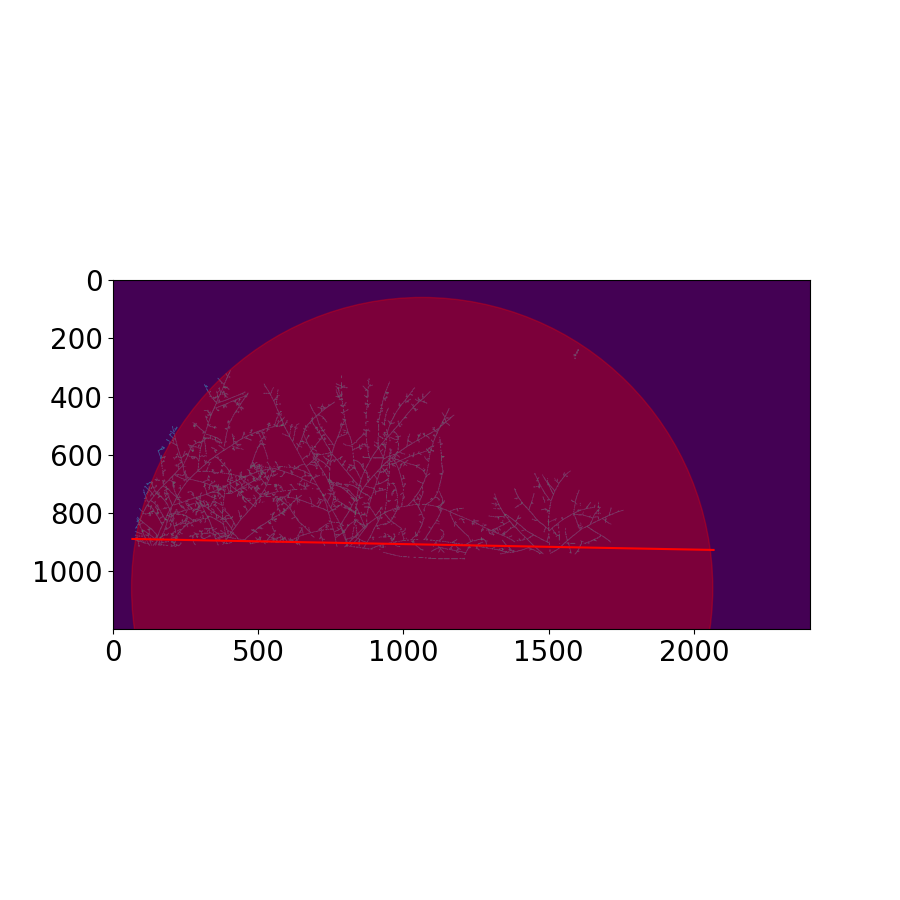

In [12]:
end = 5
plt.close('all')
compress = 25
date = exp.dates[end]
directory_name = get_dirname(date,exp.plate)
path_snap = exp.directory + directory_name
skel = read_mat(path_snap + "/Analysis/skeleton_pruned_realigned.mat")
Rot = skel["R"]
trans = skel["t"]
skelet = skel['skeleton']
output = skelet.todense()
kernel = np.ones((5,5),np.uint8)
output = cv2.dilate(output.astype(np.uint8),kernel,iterations = 3)
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111)
x,y = np.array(exp.center)[0]//compress, np.array(exp.center)[1]//compress
circle = plt.Circle((x,y),radius,alpha = 0.3,color= 'red')
pos_line = np.array((x,y))+dist*exp.orthog
orth_direct = np.array([exp.orthog[1],-exp.orthog[0]])
extension = 1000
deb_line = pos_line + extension*orth_direct
end_line = pos_line - extension*orth_direct
line = pltlines.Line2D((deb_line[0],end_line[0]),(deb_line[1],end_line[1]),color='red')
ax.add_patch(circle)
ax.add_line(line)
ax.imshow(cv2.resize(output,(output.shape[1]//compress,output.shape[0]//compress)),alpha = 1)


In [13]:
exp.reach_out = end 

In [14]:
path = f'{directory}{row["folder_analysis"]}'
np.save(f'{path}/center',exp.center)
np.save(f'{path}/orthog',exp.orthog)
np.save(f'{path}/reach_out',exp.reach_out)

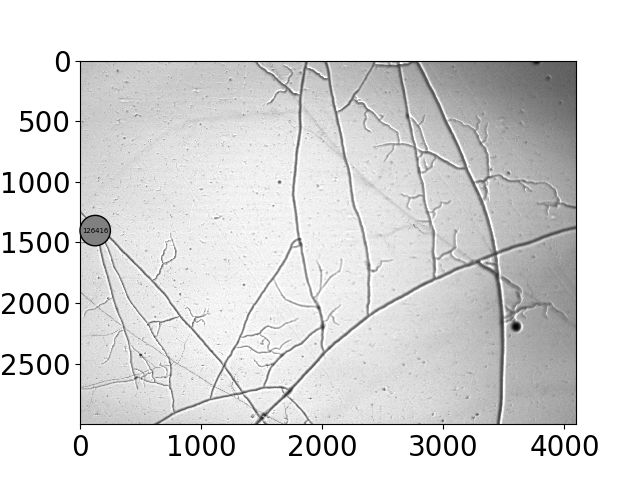

In [19]:
Node(126416, exp).show_source_image(90,90)

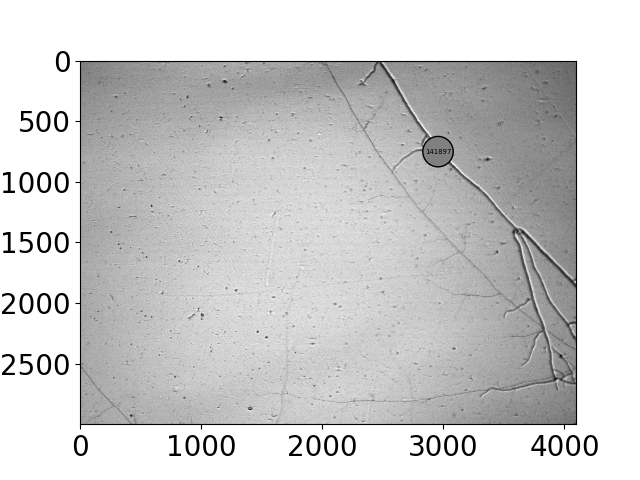

In [18]:
Edge(Node(126416, exp),Node(141897, exp)).show_source_image(90,90)

In [22]:
len(Edge(Node(126416, exp),Node(141897, exp),exp).pixel_list(90))

982

In [5]:
def get_width_info(experiment,t,resolution = 50,skip=False):
    print(not skip)
    edge_width={}
    graph = experiment.nx_graph[t]
#     print(len(list(graph.edges)))
    # print(len(graph.edges))
    print(len(graph.edges))
    # list_edges = [choice(list(graph.edges)) for i in range(100)]
    for edge in graph.edges:
        if not skip:
            # print(edge)
            edge_exp = Edge(Node(edge[0],experiment),Node(edge[1],experiment),experiment)
            mean = np.mean(list(get_width_edge(edge_exp,resolution,t).values()))
    #         print(np.mean(list(get_width_edge(edge_exp,resolution,t).values())))
            edge_width[edge]=mean
            # print(mean)
        else:
           #Maybe change to Nan if it doesnt break the rest
            edge_width[edge]=40
    return(edge_width)

In [6]:
%%time
get_width_info(exp,90,resolution = 50)

True
3361
CPU times: user 11min 16s, sys: 8min 40s, total: 19min 56s
Wall time: 20min 20s


{(34006, 73474): 9.612675112375923,
 (73446, 73474): 7.883159312472247,
 (73474, 66900): 8.868443673647091,
 (66900, 73520): 7.38230246349865,
 (66900, 60380): 8.64093034203077,
 (25219, 65009): 10.22228105053245,
 (65009, 65026): 6.2131323258844775,
 (65009, 71620): 8.597305320464958,
 (66922, 127687): 5.136192816502194,
 (127687, 73520): 6.9394187106901,
 (127687, 127693): 7.541627914549913,
 (73509, 73520): 5.920248841877464,
 (65026, 125163): 8.895471532584013,
 (65026, 34973): 9.19262013042849,
 (17186, 153371): 18.18917744157656,
 (71644, 125228): 4.843846452343988,
 (125228, 125247): 4.500905772199571,
 (125228, 71620): 6.54773738159614,
 (60380, 65297): 6.935215988934161,
 (60380, 54103): 9.001304341889263,
 (66953, 125532): 5.610571615019251,
 (71620, 125149): 5.679935487160246,
 (71620, 125163): 8.617006021918272,
 (125149, 125163): 6.110558455164888,
 (125149, 125139): 4.9234023915924086,
 (153371, 25526): 21.10654944598961,
 (153371, 116977): 10.080307324413335,
 (125532, 6

In [4]:
from skimage.measure import profile_line
from amftrack.notebooks.analysis.util import *
from scipy.optimize import curve_fit
import numpy as np
a = 2.3196552
from scipy import special
def func2(x,lapse, lapse2,c,d,e):
    return(-c*(special.erf(e*(x-lapse))-special.erf(e*(x-lapse-lapse2)))+d)
def func3(x, lapse,lapse2,c,d,e,lapse4):
    return(-c*(special.erf(e*(x-lapse))-special.erf(e*(x-(lapse+lapse2))))+d+c*(special.erf(e*(x-(lapse+lapse2)))-special.erf(e*(x-(lapse+lapse2+lapse4)))))
def func4(x, lapse,lapse2,c,d,e,lapse4):
    return(-c*(special.erf(e*(x-lapse))-special.erf(e*(x-(lapse+lapse2))))+d+c*(special.erf(e*(x-(lapse-lapse4)))-special.erf(e*(x-(lapse)))))
def func5(x, sigma, mean,fact,offset):
    return(-fact*np.exp(-(x-mean)**2/sigma**2)+offset)
def func5(x, sigma, mean,fact,offset):
    return(-fact*np.exp(-(x-mean)**2/sigma**2)+offset)
def get_source_image(experiment,pos,t,local,force_selection = None):
    x,y=pos[0],pos[1]
    ims,posimg=experiment.find_image_pos(x,y,t,local)
    if force_selection is None:
        dist_border=[min([posimg[1][i],3000-posimg[1][i],posimg[0][i],4096-posimg[0][i]]) for i in range(posimg[0].shape[0])]
        j=np.argmax(dist_border)
    else:
        dist_last=[np.linalg.norm(np.array((posimg[1][i],posimg[0][i])) - np.array(force_selection)) for i in range(posimg[0].shape[0])]
        j=np.argmin(dist_last)
    return(ims[j],(posimg[1][j],posimg[0][j]))

def get_width_pixel(edge,index,im,pivot,before,after,t,size = 20,width_factor = 60,averaging_size = 100,threshold_averaging = 10):
    imtab=im
#     print(imtab.shape)
#     print(int(max(0,pivot[0]-averaging_size)),int(pivot[0]+averaging_size))
    threshold = np.mean(imtab[int(max(0,pivot[0]-averaging_size)):int(pivot[0]+averaging_size),int(max(0,pivot[1]-averaging_size)):int(pivot[1]+averaging_size)]-threshold_averaging)
    orientation=np.array(before)-np.array(after)
    perpendicular = [1,-orientation[0]/orientation[1]] if orientation[1]!=0 else [0,1]
    perpendicular_norm=np.array(perpendicular)/np.sqrt(perpendicular[0]**2+perpendicular[1]**2)
    point1=np.around(np.array(pivot)+width_factor*perpendicular_norm)
    point2=np.around(np.array(pivot)-width_factor*perpendicular_norm)
    point1=point1.astype(int)
    point2=point2.astype(int)
    p = profile_line(imtab, point1, point2,mode='constant')
    xdata = np.array(range(len(p)))
    ydata = np.array(p)
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(xdata,ydata)
#     ax.plot(xdata, func5(xdata, *popt0), 'g-')
    # try:
    #     raise RuntimeError
    # #     p00=[10,60,60,160]
    # #     popt0, pcov = curve_fit(func5, xdata, ydata,bounds = ([0,0,0,0],4*[np.inf]),p0=p00)
    # #     p0a=[60,10,100,180,0.1]
    # #     popt1, pcov = curve_fit(func2, xdata, ydata,bounds = ([0,0,0,0,0],[120,120,200]+2*[np.inf]),p0=p0a)
    # #     p0b=list(popt1)+[10]
    # #     popt2, pcov = curve_fit(func3, xdata, ydata,bounds = ([0,0,0,0,0,0],[120,120,200]+2*[np.inf]+[120]),p0=p0b)
    # #     residuals = ydata- func3(xdata, *popt2)
    # #     ss_res = np.sum(residuals**2)
    # #     ss_tot = np.sum((ydata-np.mean(ydata))**2)
    # #     r_squared1 = 1 - (ss_res / ss_tot)
    # #     popt3, pcov = curve_fit(func4, xdata, ydata,bounds = ([0,0,0,0,0,0],[120,120,200]+2*[np.inf]+[120]),p0=p0b)
    # #     residuals = ydata- func4(xdata, *popt3)
    # #     ss_res = np.sum(residuals**2)
    # #     ss_tot = np.sum((ydata-np.mean(ydata))**2)
    # #     r_squared2 = 1 - (ss_res / ss_tot)
    # # #     ax.plot(xdata, func2(xdata, *popt1), 'r-')
    # #     if r_squared1>r_squared2:
    # # #         ax.plot(xdata, func3(xdata, *popt2), 'b-')
    # #         popt=popt2
    # #     else:
    # # #         ax.plot(xdata, func4(xdata, *popt3), 'b-')
    # #         popt=popt3
    # #     background = popt[3]
    # except RuntimeError:
    #     print('failed')
    background = np.mean((np.mean(p[:width_factor//6]),np.mean(p[-width_factor//6:])))
#     print(popt[3],popt0[3])
#     width_pix = popt0[0]*popt0[2]
    width_pix = -np.sum((np.log10(np.array(p)/background)<=0)*np.log10(np.array(p)/background))
#     print(width_pix)
#     p0=[165,100,165,45,10,10,10]
#     popt, pcov = curve_fit(func, xdata, ydata,bounds = ([-np.inf,-np.inf,-np.inf,-np.inf,0,0,0],np.inf),p0=p0)
#     width_pix = popt[-2]
#     ax.plot(xdata, func(xdata, *popt), 'r-')
#     derivative = [p[i+1]-p[i] for i in range(len(p)-1)]
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot([np.mean(derivative[5*i:5*i+5]) for i in range(len(derivative)//5)])
#     problem=False
#     arg = len(p)//2
#     if p[arg]>threshold:
#         arg = np.argmin(p)
# #     we_plot=randrange(1000)
#     while  p[arg]<=threshold:
#         if arg<=0:
# #             we_plot=50
#             problem=True
#             break
#         arg-=1
#     begin = arg
#     arg = len(p)//2
#     if p[arg]>threshold:
#         arg = np.argmin(p)
#     while  p[arg]<=threshold:
#         if arg>=len(p)-1:
# #             we_plot=50
#             problem=True
#             break
#         arg+=1
#     end = arg
# #     print(end-begin,threshold)
#     print(np.linalg.norm(point1-point2),len(p),width_pix)
    return(a*np.sqrt(max(0,np.linalg.norm(point1-point2)*(width_pix)/len(p))))

def get_width_edge(edge,resolution,t,local=False, threshold_averaging = 10):
    pixel_conversion_factor = 1.725
    pixel_list = edge.pixel_list(t)
    pixels = []
    indexes = []
    source_images = []
    poss = []
    widths={}
    if len(pixel_list)>3*resolution:
        for i in range(0,len(pixel_list)//resolution):
            index = i*resolution
            indexes.append(index)
            pixel = pixel_list[index]
            pixels.append(pixel)
            source_img,pos = get_source_image(edge.experiment,pixel,t,local)
            source_images.append(source_img)
            poss.append(pos)
    else:
        indexes = [0,len(pixel_list)//2,len(pixel_list)-1]
        for index in indexes:
            pixel = pixel_list[index]
            pixels.append(pixel)
            source_img,pos = get_source_image(edge.experiment,pixel,t,local)
            source_images.append(source_img)
            poss.append(pos)
#     print(indexes)
    for i, index in enumerate(indexes[1:-1]):
        source_img = source_images[i+1]
        pivot = poss[i+1]
        _,before = get_source_image(edge.experiment,pixels[i],t,local,pivot)
        _,after = get_source_image(edge.experiment,pixels[i+2],t,local,pivot)
#         plot_t_tp1([0,1,2],[],{0 : pivot,1 : before, 2 : after},None,source_img,source_img)
        width = get_width_pixel(edge,index,source_img,pivot,before,after,t,threshold_averaging = threshold_averaging)
#         print(width*pixel_conversion_factor)
        widths[pixel_list[index]]=width*pixel_conversion_factor
#         if i>=1:
#             break
    edge.experiment.nx_graph[t].get_edge_data(edge.begin.label,edge.end.label)['width'] = widths
    return(widths)      



In [18]:
path = f'{directory}{row["folder_analysis"]}'
exp.pickle_save(path)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


KeyboardInterrupt: 

In [27]:
select

,folder_analysis,version,Plate,PrincePos,root,strain,medium,split,Temp,CrossDate,date,Pbait,date_begin,date_end,number_timepoints,path_exp,path_analysis_info,date_run_analysis
1,Analysis_1635750896167548219_Version2,Version2,88,17,Carrot,A5,001P100N,Y,None,20210915,"22.09.2021, 23:13:",-,20210915_1507_Plate17,20211006_0900_Plate17,155,Analysis_1635750896167548219_Version2/experime...,Analysis_1635750896167548219_Version2/static_i...,"01.11.2021, 08:14:"
2,Analysis_1635751018325961431_Version2,Version2,799,39,Carrot,A5,001P100N,Y,None,20211001,"03.10.2021, 01:47:",-,20211001_1620_Plate39,20211011_1227_Plate39,95,Analysis_1635751018325961431_Version2/experime...,Analysis_1635751018325961431_Version2/static_i...,"01.11.2021, 08:16:"
7,Analysis_1635751166598733830_Version2,Version2,94,39,Carrot,A5,001P100N,Y,25,20201123,"24.11.2020, 12:02:",None,20201123_1253_Plate39,20201210_1156_Plate39,169,Analysis_1635751166598733830_Version2/experime...,Analysis_1635751166598733830_Version2/static_i...,"01.11.2021, 08:19:"
9,Analysis_1635750893830401869_Version2,Version2,80,36,Carrot,A5,001P100N,Y,None,20201127,"03.12.2020, 09:55:",-,20201128_1802_Plate36,20201206_2113_Plate36,47,Analysis_1635750893830401869_Version2/experime...,Analysis_1635750893830401869_Version2/static_i...,"01.11.2021, 08:14:"
10,Analysis_1635751691653010318_Version2,Version2,26,39,Carrot,A5,001P100N,Y,None,20210104,"10.01.2021, 03:23:",-,20210106_1122_Plate30,20210113_2325_Plate30,44,Analysis_1635751691653010318_Version2/experime...,Analysis_1635751691653010318_Version2/static_i...,"01.11.2021, 08:28:"
13,Analysis_1635750755355010260_Version2,Version2,22,29,Carrot,A5,001P100N,Y,None,20210107,"12.01.2021, 11:20:",-,20210107_1119_Plate29,20210112_2320_Plate29,31,Analysis_1635750755355010260_Version2/experime...,Analysis_1635750755355010260_Version2/static_i...,"01.11.2021, 08:12:"
14,Analysis_1635750776460268294_Version2,Version2,10,36,Carrot,A5,001P100N,Y,None,20210107,"11.01.2021, 15:33:",-,20210107_1140_Plate36,20210112_2333_Plate36,31,Analysis_1635750776460268294_Version2/experime...,Analysis_1635750776460268294_Version2/static_i...,"01.11.2021, 08:12:"
17,Analysis_1635751724713025062_Version2,Version2,91,37,Carrot,A5,001P100N,Y,None,20201217,"26.12.2020, 07:42:",-,20201217_1611_Plate37,20210105_2338_Plate37,112,Analysis_1635751724713025062_Version2/experime...,Analysis_1635751724713025062_Version2/static_i...,"01.11.2021, 08:28:"
18,Analysis_1635752856157447067_Version2,Version2,76,38,Carrot,A5,001P100N,Y,None,20210108,"10.01.2021, 11:44:",-,20210108_1143_Plate38,20210112_2337_Plate38,25,Analysis_1635752856157447067_Version2/experime...,Analysis_1635752856157447067_Version2/static_i...,"01.11.2021, 08:47:"


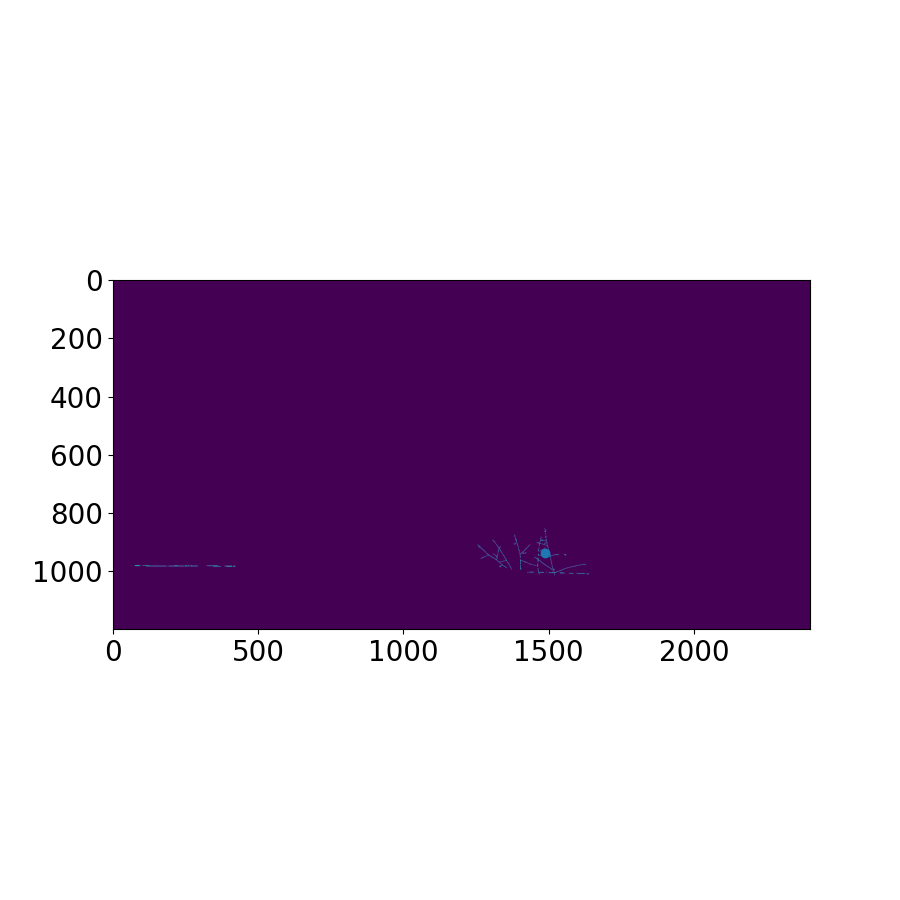

In [4]:
plt.close('all')
compress = 25
date = exp.dates[i]
directory_name = get_dirname(date,exp.plate)
path_snap = exp.directory + directory_name
skel = read_mat(path_snap + "/Analysis/skeleton_pruned_realigned.mat")
Rot = skel["R"]
trans = skel["t"]
skelet = skel['skeleton']
output = skelet.todense()
kernel = np.ones((5,5),np.uint8)
output = cv2.dilate(output.astype(np.uint8),kernel,iterations = 3)
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111)
ax.imshow(cv2.resize(output,(output.shape[1]//compress,output.shape[0]//compress)),alpha = 1)
plt.scatter(exp.center[0]//compress,exp.center[1]//compress)

In [126]:
Node(77,exp)

Node(77)

In [33]:
is_in_study_zone(Node(223,exp),t)

(False, True)

In [70]:
np.all((True,False))

False

In [13]:
t= 0
compress = 25
center = np.array(exp.center)
poss = exp.positions[t]
x0,y0 = exp.center
direction = exp.orthog
pos_line = np.array((x0,y0))+dist*compress*direction
x_line,y_line = pos_line[0],pos_line[1]
orth_direct = np.array([direction[1],-direction[0]])
x_orth,y_orth = orth_direct = orth_direct[0],orth_direct[1]
a = y_orth/x_orth
b = y_line-a*x_line
nodes_exclude = []
for node in exp.nx_graph[t].nodes:
    dist_center = np.linalg.norm(poss[node]-center)
    y,x = poss[node]
    if dist_center > radius*compress or a*x+b<y:
        nodes_exclude.append(node)


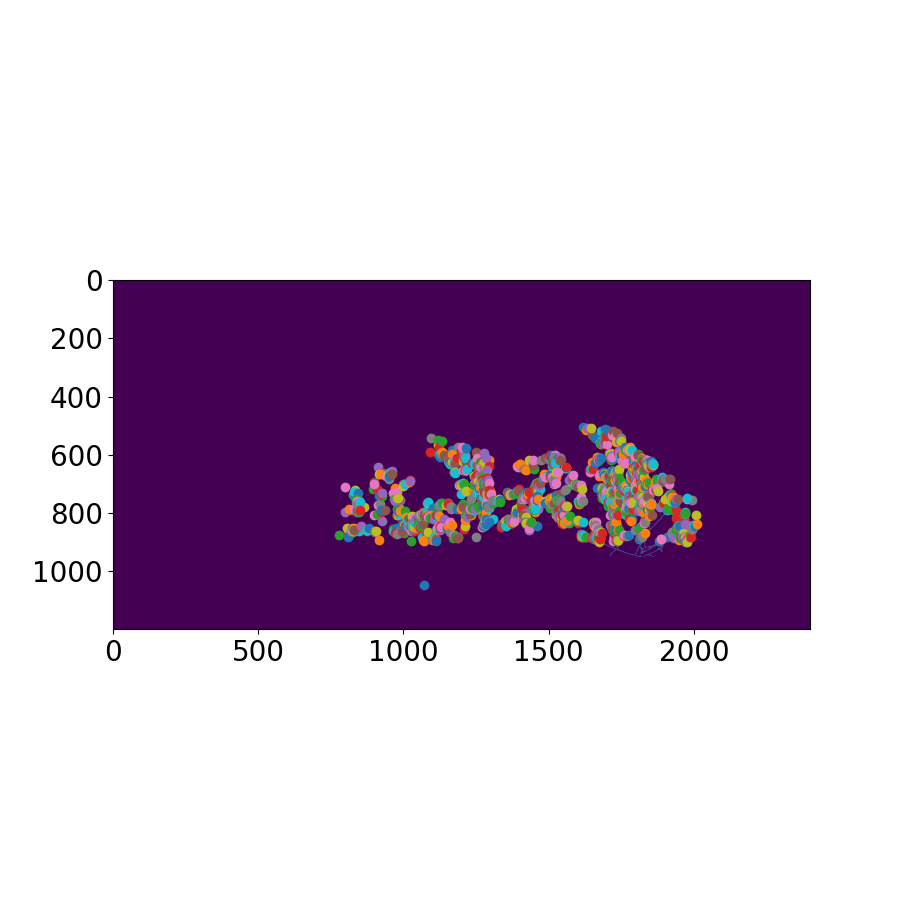

In [15]:
plt.close('all')
compress = 25
date = exp.dates[i]
directory_name = get_dirname(date,exp.plate)
path_snap = exp.directory + directory_name
skel = read_mat(path_snap + "/Analysis/skeleton_pruned_realigned.mat")
Rot = skel["R"]
trans = skel["t"]
skelet = skel['skeleton']
output = skelet.todense()
kernel = np.ones((5,5),np.uint8)
output = cv2.dilate(output.astype(np.uint8),kernel,iterations = 3)
fig = plt.figure(figsize = (9,9))
ax = fig.add_subplot(111)
ax.imshow(cv2.resize(output,(output.shape[1]//compress,output.shape[0]//compress)),alpha = 1)
plt.scatter(exp.center[0]//compress,exp.center[1]//compress)
plt.scatter(x_line//compress,y_line//compress)
for node in exp.nx_graph[t].nodes:
    if node not in nodes_exclude:
        s=plt.scatter(*np.flip(poss[node])//compress)